In [12]:
%%time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from raw_data import utils

CPU times: user 340 ms, sys: 28 ms, total: 368 ms
Wall time: 369 ms


In [13]:
class MetaClassConfig:
    def __init__(self, name, aesth_lists, max_imgs=None):
        self.name = name
        self.aesth_lists = aesth_lists
        self.max_imgs = max_imgs

In [40]:
meta_class_configs = [
    MetaClassConfig('small_generic', ['generic_ls_train.jpgl', 'generic_ss_train.jpgl', 'generic_test.jpgl'], 100),
    MetaClassConfig('portraits', ['portrait_test.jpgl', 'portrait_train.jpgl']),
]

In [15]:
def load_ava_df():
    return pd.read_csv('raw_data/AVA_dataset/AVA.txt', sep=' ', 
                     names=['id', 1,2,3,4,5,6,7,8,9,10, 'tag1', 'tag2', 'challenge'])

In [16]:
ava_df = load_ava_df()
ava_df.sample(4)

id   1   2   3   4   5   6   7   8  9  10  tag1  tag2  challenge
100306  167995   0   1   5  21  74  77  35  18  8   2    15    38        322
69378   598020   2   2   7  40  63  52  27   8  3   1    15    19        753
178024  925733   0   1   5   7  51  56  21   3  2   1    10    20       1314
49428   111371  26  26  63  66  56  18   4   1  3   1    23     0        266

In [17]:
def process_df(df):
    """
    Creates and returns a copy of the dataframe with the addition of 
    • score (weighted mean of the votes)
    • standard deviation
    • normalized score
    • normalized standard deviation
    • randomly splits it into train/test sets 80-20
    """
    # Deep copy
    df = df.copy()
    
    # Calculate mean score
    votes = np.zeros(len(df))
    score = np.zeros(len(df))
    for i in range(1, 11):
        votes += df[i]
        score += i * df[i]

    df['score'] = score / votes
    
    # Calculate sum of square differences between scores and mean score
    squared_difference = np.zeros(df.shape[0])
    for i in range(1, 11):
        squared_difference += df[i] * ((df['score'] - i)**2)
    
    # Standard deviation
    df['std'] = np.sqrt(squared_difference / votes)
    
    # Normalize score
    df['norm_score'] = (df['score'] - df['score'].mean()) / df['score'].std()
    
    # Normalize std
    df['norm_std'] = (df['std'] - df['std'].mean()) / df['std'].std()
    
    df['subset'] = None
    
    train = df.sample(frac=0.8)
    df.loc[df.index.isin(train.index), 'subset'] = 'train'    
    df.loc[pd.isna(df['subset']), 'subset'] = 'test'

    return df

In [18]:
from skimage.transform import rescale
def resize_and_trim_to_aspect_ratio(image, size):
    """
    Trims the edges such that the image meets the aspect ratio of the size and the image is centered, 
    and then scales it down to the size
    :param image:
    :param size:
    :return:
    """

    center = (image.shape[0] // 2, image.shape[1] // 2)
    row_factor = image.shape[0] / size[0]
    column_factor = image.shape[1] / size[1]

    limiting_factor = min(row_factor, column_factor)

    cropped_size = (int(size[0] * limiting_factor), int(size[1] * limiting_factor))

    image = image[center[0] - (cropped_size[0] // 2) : center[0] + (cropped_size[0] // 2), 
                  center[1] - (cropped_size[1] // 2) : center[1] + (cropped_size[1] // 2)]

    image = rescale(image, min(size[0] / image.shape[0], size[1] / image.shape[1]), 
                    anti_aliasing=True, preserve_range=True, multichannel=True, mode='reflect').astype('uint8')

    return image

In [19]:
import os
import shutil
from PIL import Image
def gen_meta_class_data(df, name):
    new_dir = 'processed_data/{}/'.format(name)
    if os.path.exists(new_dir):
        shutil.rmtree(new_dir)
    os.makedirs(new_dir)
    
    df.to_csv(new_dir + 'df.csv', index=False)
    
    # Plot samples
    plt.figure(figsize=(30, 30))
    plt.title('Samples')
    
    sorted_df = df.sort_values(by='norm_score')
    num_rows = len(sorted_df)
    interval = int(num_rows / 16)
    for i in range(16):
        plt.subplot(4, 4, i + 1)
        done = False
        for j, row in sorted_df[interval * i: interval * (i + 1)].iterrows():
            image_id = int(row['id'])
            
            # It's possible that the image may not exist
            try:
                img = Image.open('raw_data/AVA_dataset/images/all_images/{}.jpg'.format(image_id)).convert('RGB')
                img_array = np.asarray(img)
                img_array = resize_and_trim_to_aspect_ratio(img_array, (256, 256))
                plt.imshow(img_array)
                plt.xlabel('{} | {}'.format(round(row['norm_score'], 3), round(row['norm_std']), 3))
                # Successfully loaded an image. Move on to the next
                break
            except Exception as e:
                print(e)
                pass
    plt.savefig(new_dir + 'samples.png')
    
    # Plot score and std distribution
    plt.figure()
    with sns.axes_style("white"):
        sns.jointplot(x="norm_score", y="norm_std", data=df, kind='hex', color='k')
    plt.savefig(new_dir + 'val_distr.png')
    
    

CPU times: user 7.27 s, sys: 72 ms, total: 7.34 s
Wall time: 7.4 s


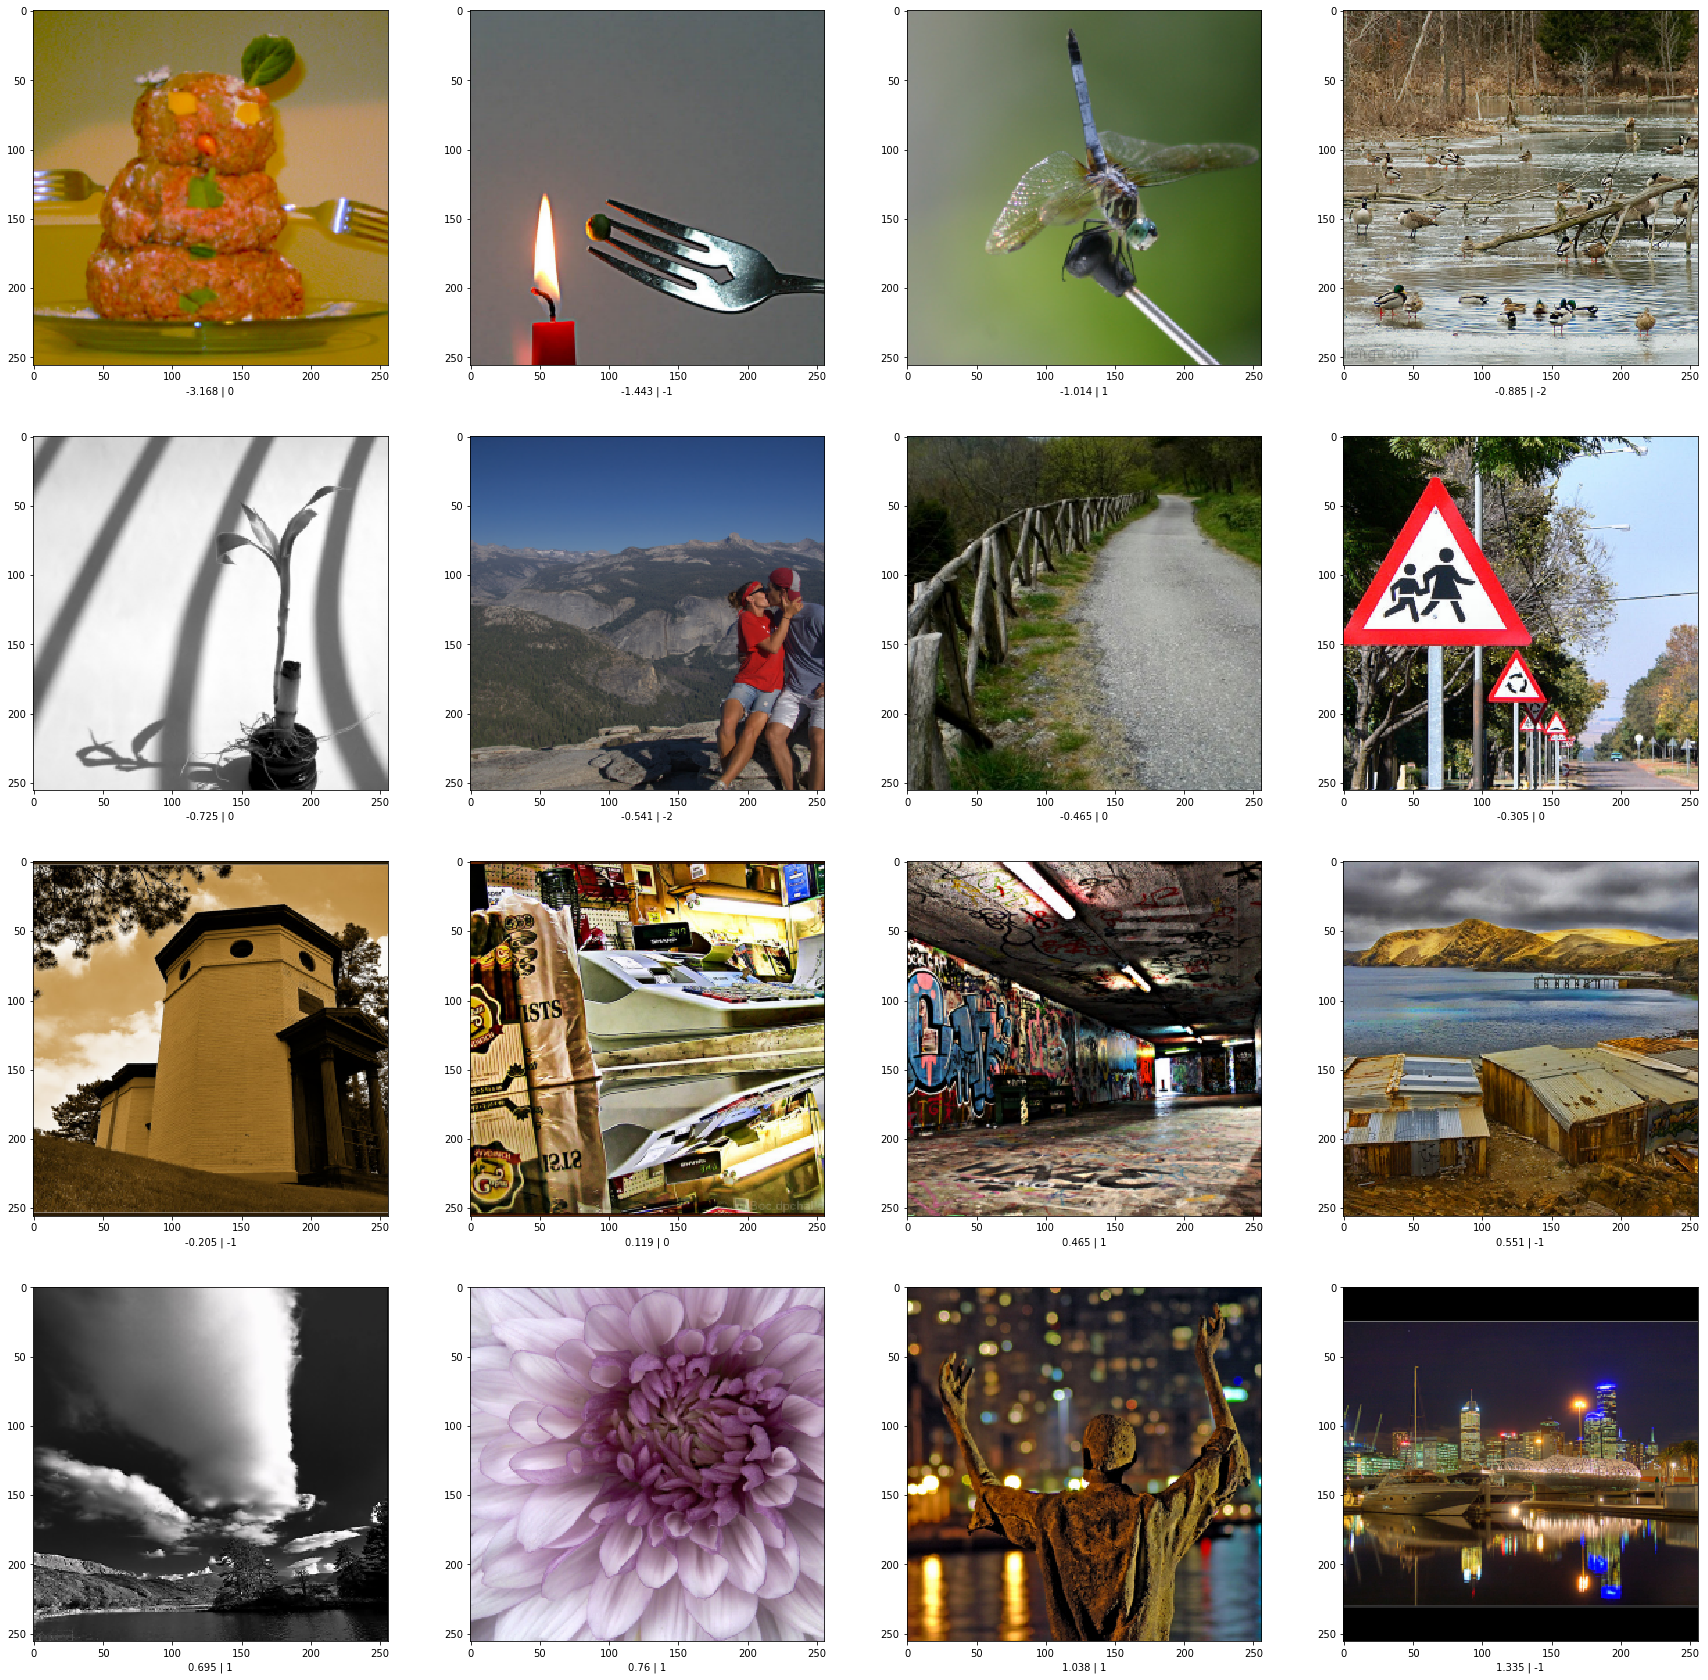

<Figure size 432x288 with 0 Axes>

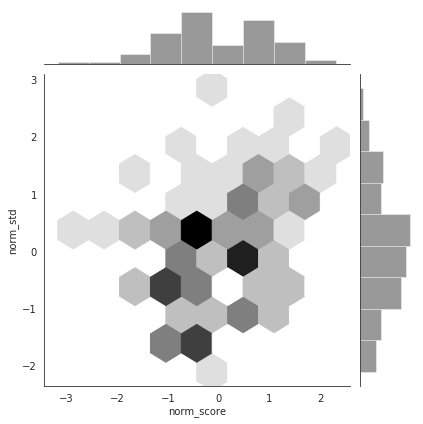

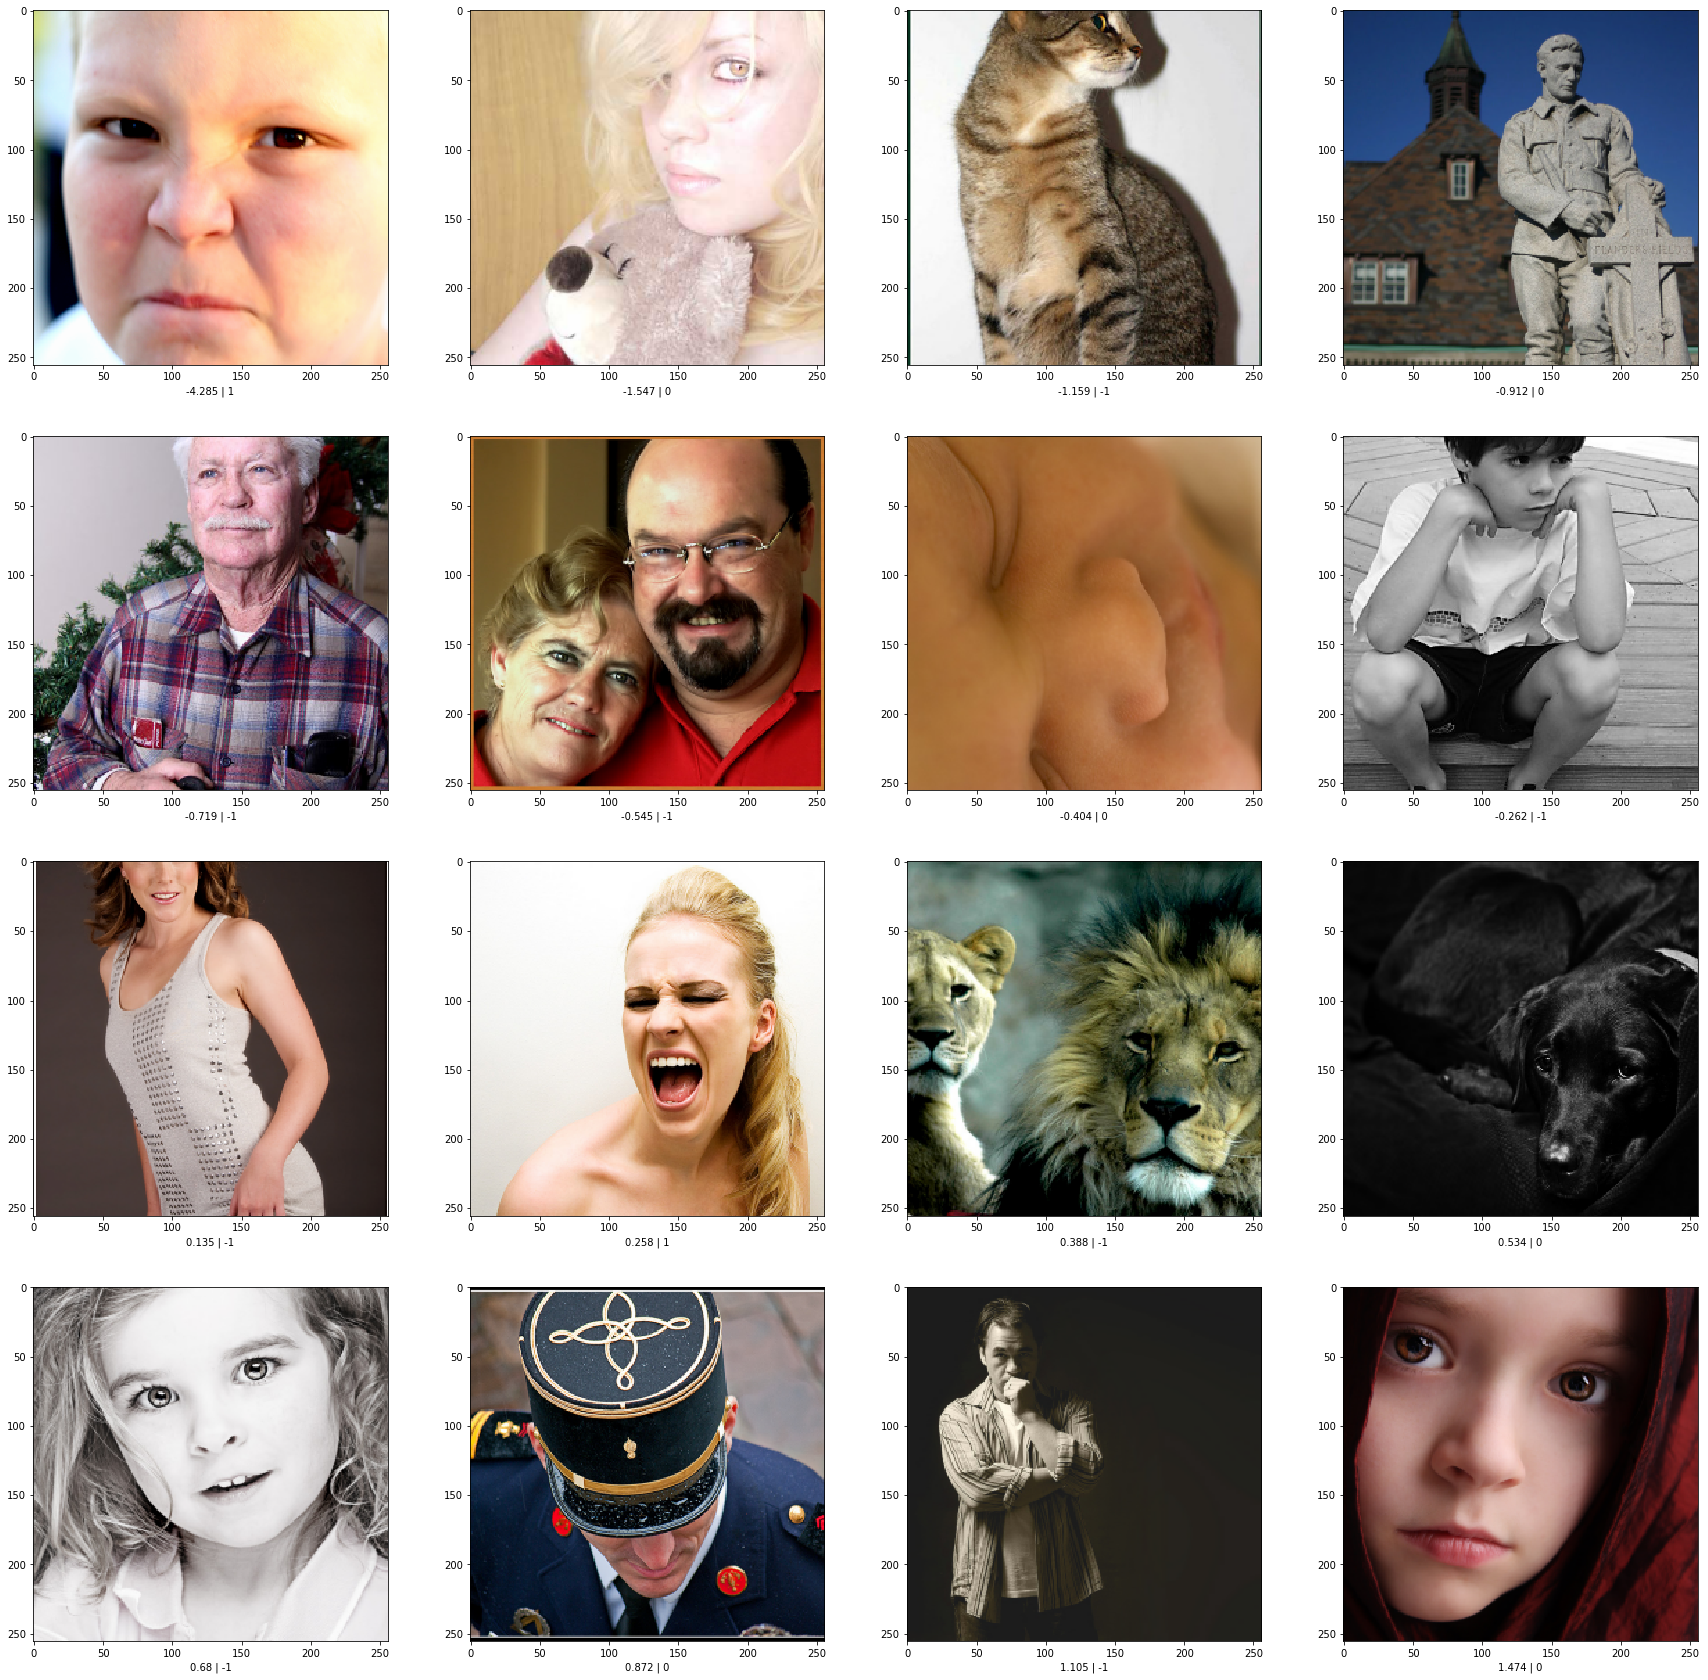

<Figure size 432x288 with 0 Axes>

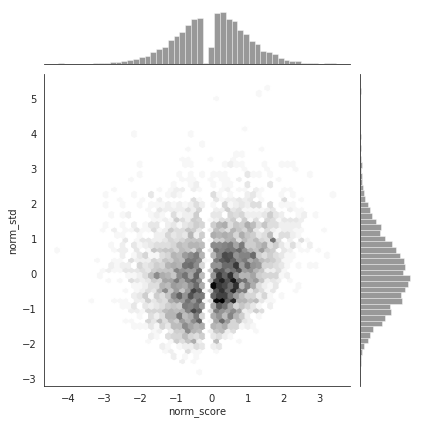

In [41]:
%%time
for mc_config in meta_class_configs:
    ava_df = load_ava_df()
    
    curr_df = pd.DataFrame(columns=[0])
    for aesth_list in mc_config.aesth_lists:
        df = pd.read_csv('raw_data/AVA_dataset/aesthetics_image_lists/{}'.format(aesth_list), header=None)
        curr_df = curr_df.merge(df, 'outer')
    
    if mc_config.max_imgs is not None:
        curr_df = curr_df.sample(mc_config.max_imgs)
    
    num_imgs = len(curr_df)
    
    curr_df = ava_df.merge(curr_df, left_on='id', right_on=0)
    
    curr_df = curr_df.drop(columns=[0])
    
    curr_df = process_df(curr_df)
    
    gen_meta_class_data(curr_df, mc_config.name)
    

In [37]:
def write_images(df, output_directory, new_size):
    """
    Writes all images in a dataframe to an output directory
    """
    if not os.path.exists(output_directory):
        os.mkdir(output_directory)
    
    num_imgs_missing = 0
    
    for i, row in df.iterrows():
        image_id = int(row['id'])
        input_file_path = 'raw_data/AVA_dataset/images/all_images/{}.jpg'.format(image_id)
        output_file_path = '{}/{}.png'.format(output_directory, image_id)

        if os.path.exists(output_file_path):
            continue

        try:
            img = Image.open(input_file_path).convert('RGB')
            img_array = np.asarray(img)
            img_array = resize_and_trim_to_aspect_ratio(img_array, new_size)
            img = Image.fromarray(img_array, mode="RGB")
            img.save(output_file_path)
        except Exception as e:
            num_imgs_missing += 1
    print('{} missed images'.format(num_imgs_missing))

In [38]:
import os
import pandas as pd
def make_img_pool(shape):
    meta_classes = os.listdir('processed_data/')
    meta_classes = list(filter(lambda name: '.' not in name and name != 'image_pool', meta_classes))
    empty_df = pd.DataFrame(columns=[0])
    
    output_path = 'processed_data/image_pool/{}_{}/'.format(shape[0], shape[1])
    
    if not os.path.exists(output_path):
        os.mkdir(output_path)
        
    for meta_class in meta_classes:
        df = pd.read_csv('processed_data/{}/df.csv'.format(meta_class))
        write_images(df, output_path, shape)

In [42]:
%%time
make_img_pool((256, 256))

2 missed images
0 missed images
CPU times: user 4.46 s, sys: 52 ms, total: 4.51 s
Wall time: 4.76 s
